In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
import seaborn as sns

from scipy import stats

from sklearn.linear_model import LinearRegression

In [20]:
labels_table = pd.read_csv('../seasonality_pattern/seasonality_patterns.csv')
product_list = list(labels_table.product_id)
display(len(product_list))
colours_feature = pd.read_csv('../dataset/final/final/new_features/colors_name-2.csv', index_col = 0)
composition_feature = pd.read_csv('../dataset/final/final/new_features/composition.csv')
month_features_table = pd.read_csv('launch_month_feature.csv')

colours_feature = colours_feature[colours_feature.product_id.isin(product_list)]
composition_feature = composition_feature[composition_feature.product_id.isin(product_list)]
month_features = month_features_table[month_features_table.product_id.isin(product_list)]

raw_features = pd.read_csv('for_EDA.csv')
raw_features = raw_features[raw_features.product_id.isin(product_list)]

all_raw_features = pd.merge(raw_features, colours_feature, on = 'product_id')
all_raw_features = pd.merge(all_raw_features, composition_feature, on = 'product_id', how = 'left')
all_raw_features = pd.merge(all_raw_features, month_features, on = 'product_id', how = 'left')
all_raw_features = all_raw_features.merge(labels_table[['product_id','cluster_num']], on = 'product_id')

display(all_raw_features.shape)
features_list = list(all_raw_features)
features_list.remove('category type')
all_raw_features = all_raw_features[features_list]
all_raw_features = all_raw_features[['product_id','name', 'style','price','color',
                                     'launch_month','cluster_num']]
display(all_raw_features.head())
display(all_raw_features.shape)

1362

(1362, 15)

,product_id,name,style,price,color,launch_month,cluster_num
0,2134,T-shirt à message,T-Shirt standard 45-65cm-Manches courtes-Col r...,4.0,grey,2,0
1,2135,T-shirt brodé,T-Shirt standard 45-65cm-Manches courtes-Col r...,4.0,black,2,5
2,2136,T-shirt brodé,T-Shirt standard 45-65cm-Manches courtes-Col r...,4.0,white,2,5
3,2137,T-shirt imprimé,T-Shirt standard 45-65cm-Manches courtes-Col r...,4.0,black,1,5
4,2138,T-shirt imprimé,T-Shirt standard 45-65cm-Manches courtes-Col r...,4.0,black,1,0


(1362, 7)

In [115]:
all_features_table = pd.read_csv('../dataset/final/final/new_features/human_features.csv')
all_features_table = all_features_table[all_features_table.product_id.isin(product_list)]
EDA_composition = all_features_table.merge(labels[['product_id','cluster_num']], on = 'product_id')
display(EDA_composition.head())
display(EDA_composition.shape)

,product_id,body,bretelles,cache_coeur,col_batea,col_bateau,col_bénit,col_bénitier,col_carré,col_fendu,...,Lin,Lyocell,Metal/ metallique,Modal,Polyamide,Polyamide enduit,Polyester,Polypropylene,Viscose,cluster_num
0,2134,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2135,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,2136,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,2137,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,2138,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(1362, 71)

# Deal with style

In [23]:
all_raw_features['style'] = all_raw_features['style'].fillna('0-0-0')
all_raw_features['style'] = all_raw_features['style'].str.lower()
all_raw_features['style'] = all_raw_features['style'].str.replace('45-65cm','45/65cm')
all_raw_features['style'] = all_raw_features['style'].str.replace('cache-coeur','cache_coeur')
all_raw_features['style'] = all_raw_features['style'].str.replace('t-shirt','tshirt')
all_raw_features['style'] = all_raw_features['style'].str.replace(' ','_')
all_raw_features['style'] = all_raw_features['style'].apply(lambda x: ' '.join(c for c in x.split('-')))
display(all_raw_features.head())

,product_id,name,style,price,color,launch_month,cluster_num
0,2134,T-shirt à message,tshirt_standard_45/65cm manches_courtes col_rond,4.0,grey,2,0
1,2135,T-shirt brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,2,5
2,2136,T-shirt brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,white,2,5
3,2137,T-shirt imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,5
4,2138,T-shirt imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,0


In [24]:
display(all_raw_features.loc[0,'style'].split())
style_list = []
for i in range(len(all_raw_features)):
    style_list.append(all_raw_features.loc[i,'style'].split()[0])
    style_list.append(all_raw_features.loc[i,'style'].split()[1])
    style_list.append(all_raw_features.loc[i,'style'].split()[2])
style_array = np.array(style_list).reshape(len(all_raw_features),3)
display(style_array)
all_raw_features['style_shape'] = style_array[:,0]
all_raw_features['style_sleeve'] = style_array[:,1]
all_raw_features['style_collar'] = style_array[:,2]

all_raw_features['style_shape'] = all_raw_features['style_shape'].str.replace('45/65cm','45-65cm')

all_raw_features['style_collar'] = all_raw_features['style_collar'].str.replace('col_batea','col_bateau')
all_raw_features['style_collar'] = all_raw_features['style_collar'].str.replace('col_bateauu','col_bateau')
display(all_raw_features.head())

['tshirt_standard_45/65cm', 'manches_courtes', 'col_rond']

array([['tshirt_standard_45/65cm', 'manches_courtes', 'col_rond'],
       ['tshirt_standard_45/65cm', 'manches_courtes', 'col_rond'],
       ['tshirt_standard_45/65cm', 'manches_courtes', 'col_rond'],
       ...,
       ['tshirt_standard_45/65cm', 'sans_manches', 'col_rond'],
       ['tshirt_standard_45/65cm', 'sans_manches', 'col_rond'],
       ['tshirt_standard_45/65cm', 'sans_manches', 'col_rond']],
      dtype='<U23')

,product_id,name,style,price,color,launch_month,cluster_num,style_shape,style_sleeve,style_collar
0,2134,T-shirt à message,tshirt_standard_45/65cm manches_courtes col_rond,4.0,grey,2,0,tshirt_standard_45-65cm,manches_courtes,col_rond
1,2135,T-shirt brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,2,5,tshirt_standard_45-65cm,manches_courtes,col_rond
2,2136,T-shirt brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,white,2,5,tshirt_standard_45-65cm,manches_courtes,col_rond
3,2137,T-shirt imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,5,tshirt_standard_45-65cm,manches_courtes,col_rond
4,2138,T-shirt imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,0,tshirt_standard_45-65cm,manches_courtes,col_rond


# Deal with name

In [25]:
name_feature_list = ['basique','brodé','cropped','côtelé','dentelle','débardeur',
                     'fines','imprimé','maille','message']
print(name_feature_list)

['basique', 'brodé', 'cropped', 'côtelé', 'dentelle', 'débardeur', 'fines', 'imprimé', 'maille', 'message']


In [26]:
all_raw_features['name'] = all_raw_features['name'].str.lower()
all_raw_features['name'] = all_raw_features['name'].fillna('0')
display(all_raw_features.head())
all_raw_features['name'] = all_raw_features['name'].str.split()

,product_id,name,style,price,color,launch_month,cluster_num,style_shape,style_sleeve,style_collar
0,2134,t-shirt à message,tshirt_standard_45/65cm manches_courtes col_rond,4.0,grey,2,0,tshirt_standard_45-65cm,manches_courtes,col_rond
1,2135,t-shirt brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,2,5,tshirt_standard_45-65cm,manches_courtes,col_rond
2,2136,t-shirt brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,white,2,5,tshirt_standard_45-65cm,manches_courtes,col_rond
3,2137,t-shirt imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,5,tshirt_standard_45-65cm,manches_courtes,col_rond
4,2138,t-shirt imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,0,tshirt_standard_45-65cm,manches_courtes,col_rond


In [27]:
for i in range(len(all_raw_features)):
    word_str = ''
    for word in all_raw_features.loc[i,'name']:
        if word in name_feature_list:
            word_str += word
            word_str += ' '
    if len(word_str)>0 and word_str[-1] == ' ':
        word_str = word_str[:-1]
    else:
        word_str = 'NaN'
    all_raw_features.loc[i,'name'] = word_str

In [28]:
## some products' names have two words!!!!!
all_raw_features['name'] = all_raw_features['name'].str.replace('fines dentelle','dentelle')
all_raw_features['name'] = all_raw_features['name'].str.replace('cropped côtelé','côtelé')
all_raw_features['name'] = all_raw_features['name'].str.replace('basique fines','basique')
all_raw_features['name'] = all_raw_features['name'].str.replace('débardeur dentelle','débardeur')
all_raw_features['name'] = all_raw_features['name'].str.replace('débardeur brodé','débardeur')
all_raw_features['name'] = all_raw_features['name'].str.replace('débardeur côtelé','débardeur')
all_raw_features['name'] = all_raw_features['name'].str.replace('débardeur maille','débardeur')
all_raw_features['name'] = all_raw_features['name'].str.replace('débardeur basique','basique')
# débardeur dentelle       9
# débardeur brodé          7
# débardeur côtelé         3
# débardeur maille         1
# débardeur basique       66
display(all_raw_features.head())
print(all_raw_features.name.unique())


,product_id,name,style,price,color,launch_month,cluster_num,style_shape,style_sleeve,style_collar
0,2134,message,tshirt_standard_45/65cm manches_courtes col_rond,4.0,grey,2,0,tshirt_standard_45-65cm,manches_courtes,col_rond
1,2135,brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,2,5,tshirt_standard_45-65cm,manches_courtes,col_rond
2,2136,brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,white,2,5,tshirt_standard_45-65cm,manches_courtes,col_rond
3,2137,imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,5,tshirt_standard_45-65cm,manches_courtes,col_rond
4,2138,imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,0,tshirt_standard_45-65cm,manches_courtes,col_rond


['message' 'brodé' 'imprimé' 'NaN' 'fines' 'débardeur' 'cropped'
 'dentelle' 'basique' 'maille' 'côtelé']


In [29]:
all_raw_features = all_raw_features.fillna('NaN')
display(all_raw_features.head())
display(all_raw_features.shape)

,product_id,name,style,price,color,launch_month,cluster_num,style_shape,style_sleeve,style_collar
0,2134,message,tshirt_standard_45/65cm manches_courtes col_rond,4.0,grey,2,0,tshirt_standard_45-65cm,manches_courtes,col_rond
1,2135,brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,2,5,tshirt_standard_45-65cm,manches_courtes,col_rond
2,2136,brodé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,white,2,5,tshirt_standard_45-65cm,manches_courtes,col_rond
3,2137,imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,5,tshirt_standard_45-65cm,manches_courtes,col_rond
4,2138,imprimé,tshirt_standard_45/65cm manches_courtes col_rond,4.0,black,1,0,tshirt_standard_45-65cm,manches_courtes,col_rond


(1362, 10)

# Overall label

1    230
4    190
2    187
0    175
3    163
6    157
5    132
7    128
Name: cluster_num, dtype: int64


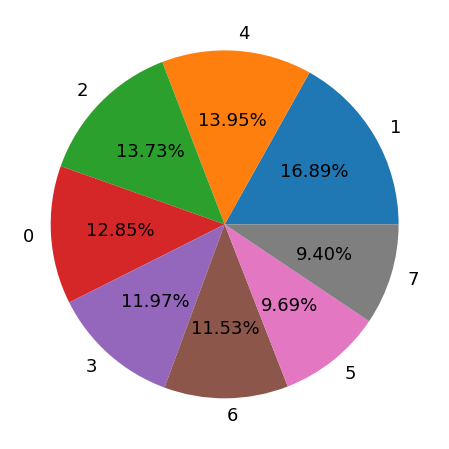

In [155]:
plt.figure(figsize=(8,8))
# plt.title("Distribution of season",fontsize = 11)
sorted_counts = all_raw_features['cluster_num'].value_counts()
print(sorted_counts)
patches,l_text,p_text = plt.pie(x=sorted_counts,labels=sorted_counts.index,autopct="%0.2f%%")
for t in l_text:
    t.set_size(18)
for t in p_text:
    t.set_size(18)

plt.savefig("../../saved_figs/task2/Pie chart of labels.pdf",dpi=1200,bbox_inches = 'tight')
plt.show()

# launch month

12    266
1     181
5     125
7     124
8     121
6     111
4      96
3      95
11     73
9      69
10     64
2      37
Name: launch_month, dtype: int64


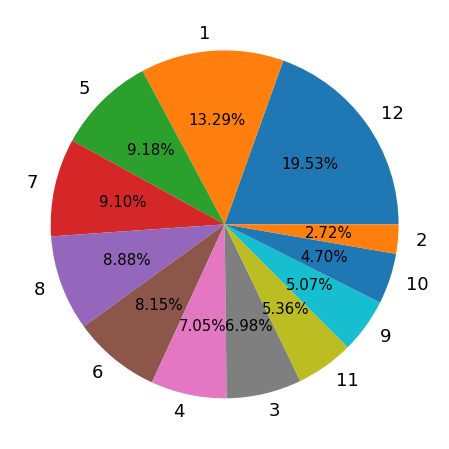

In [158]:
plt.figure(figsize=(8,8))
# plt.title("Distribution of season",fontsize = 11)
sorted_counts = all_raw_features['launch_month'].value_counts()
print(sorted_counts)
patches,l_text,p_text=plt.pie(x=sorted_counts,labels=sorted_counts.index,autopct="%0.2f%%")
for t in l_text:
    t.set_size(18)
for t in p_text:
    t.set_size(15)

plt.savefig("../../saved_figs/task2/Pie chart of launch month.pdf",dpi=1200,bbox_inches = 'tight')
plt.show()

12    266
1     181
5     125
7     124
8     121
Name: launch_month, dtype: int64


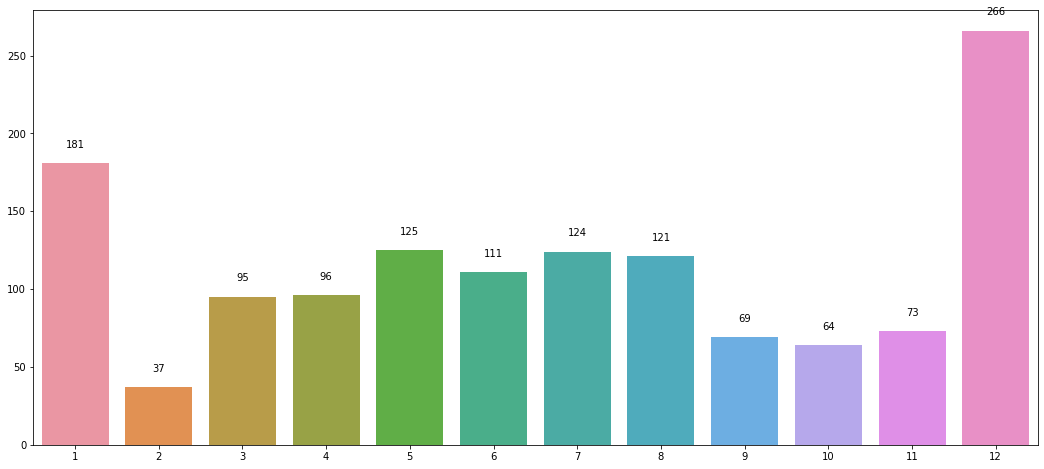

In [36]:
plt.figure(figsize=(18,8))
sorted_counts = all_raw_features['launch_month'].value_counts()
print(sorted_counts.head())
g = sns.barplot(x=sorted_counts.index,y=sorted_counts.values)
rank = sorted(list(sorted_counts.index))
rank_dict = {}
for i in range(len(rank)):
    rank_dict[rank[i]] = i
for i in range(len(sorted_counts)):
    g.text(rank_dict[sorted_counts.index[i]],sorted_counts.values[i]+10,sorted_counts.values[i],color="black",ha="center")
# plt.savefig("../../saved_figs/.pdf",dpi=1200)
plt.show()

In [132]:
display(all_raw_features.groupby('launch_month')['cluster_num'].value_counts().unstack())

cluster_num,0,1,2,3,4,5,6,7
launch_month,,,,,,,,
1,73.0,46.0,1.0,NaN,8.0,47.0,6.0,NaN
2,20.0,7.0,NaN,NaN,6.0,4.0,NaN,NaN
3,NaN,32.0,1.0,NaN,4.0,58.0,NaN,NaN
4,NaN,59.0,NaN,NaN,18.0,19.0,NaN,NaN
5,NaN,78.0,3.0,NaN,44.0,NaN,NaN,NaN
6,1.0,1.0,23.0,NaN,79.0,NaN,1.0,6.0
7,1.0,NaN,78.0,NaN,25.0,NaN,6.0,14.0
8,NaN,NaN,76.0,7.0,NaN,NaN,3.0,35.0
9,2.0,NaN,3.0,3.0,1.0,NaN,7.0,53.0


In [175]:
corr = all_raw_features.groupby('launch_month')['cluster_num'].value_counts().unstack()
display(corr)
corr.to_csv('Task2/month_corr.csv')

cluster_num,0,1,2,3,4,5,6,7
launch_month,,,,,,,,
1,73.0,46.0,1.0,NaN,8.0,47.0,6.0,NaN
2,20.0,7.0,NaN,NaN,6.0,4.0,NaN,NaN
3,NaN,32.0,1.0,NaN,4.0,58.0,NaN,NaN
4,NaN,59.0,NaN,NaN,18.0,19.0,NaN,NaN
5,NaN,78.0,3.0,NaN,44.0,NaN,NaN,NaN
6,1.0,1.0,23.0,NaN,79.0,NaN,1.0,6.0
7,1.0,NaN,78.0,NaN,25.0,NaN,6.0,14.0
8,NaN,NaN,76.0,7.0,NaN,NaN,3.0,35.0
9,2.0,NaN,3.0,3.0,1.0,NaN,7.0,53.0


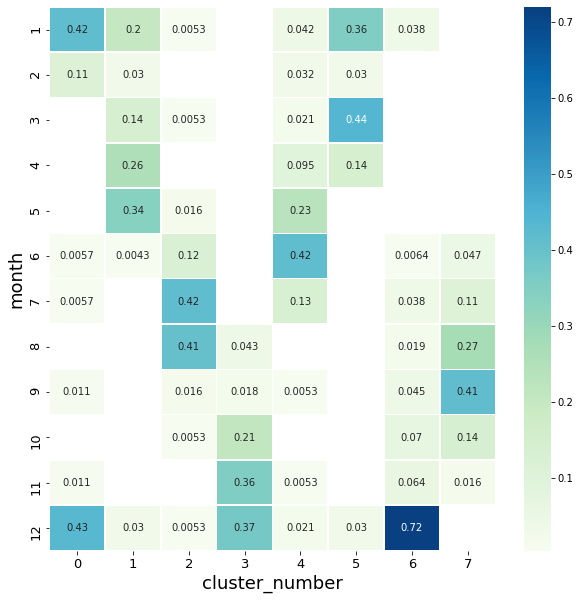

In [176]:
corr_scaled = corr.copy(deep = True)
for i in range(a.shape[1]):
    corr_scaled.iloc[:,i] /= corr_scaled.sum()[i]
plt.figure(figsize=(10,10))
sns.heatmap(corr_scaled,annot=True,cmap='GnBu',linewidths=0.5) 
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel('cluster_number',fontsize = 18)
plt.ylabel('month',fontsize = 18)
plt.savefig('../../saved_figs/task2/month heat map.pdf', dpi = 1200,bbox_inches = 'tight')
plt.show()

# price

/Users/johnsonqi/opt/anaconda3/envs/MLPR/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


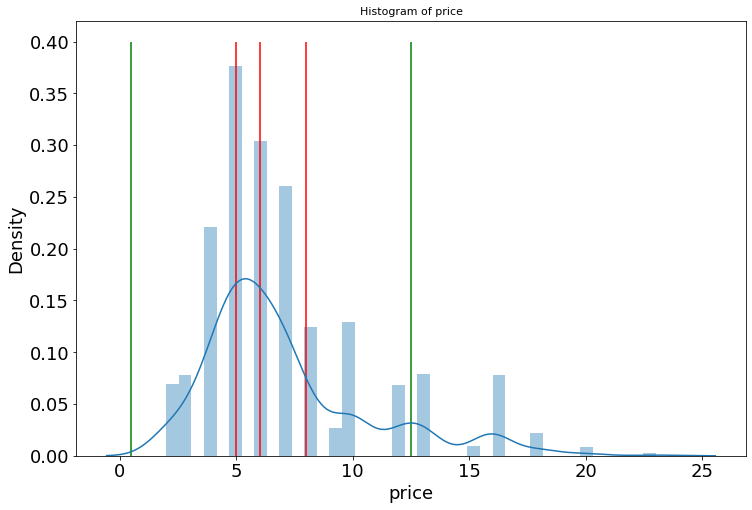

In [172]:
plt.figure(figsize=(12,8))
price = all_raw_features['price'].values
sns.distplot(price,kde = True).set_title('Histogram of price',fontsize = 11)

Q1 = all_raw_features['price'].quantile(0.25)
Q2 = all_raw_features['price'].quantile(0.5)
Q3 = all_raw_features['price'].quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5 *IQR
upper = Q3 + 1.5 *IQR
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)


plt.vlines(Q1,0,0.4,color="red")
plt.vlines(Q2,0,0.4,color="red")
plt.vlines(Q3,0,0.4,color="red")
plt.vlines(lower,0,0.4,color="green")
plt.vlines(upper,0,0.4,color="green")
plt.xlabel('price',fontsize = 18)
plt.ylabel('Density',fontsize = 18)
plt.savefig("../../saved_figs/task2/shape of price.pdf",dpi=600,bbox_inches = 'tight')
plt.show()

In [127]:
display(all_raw_features.groupby('price')['cluster_num'].value_counts().unstack())

cluster_num,0,1,2,3,4,5,6,7
price,,,,,,,,
2.0,13.0,15.0,2.0,NaN,8.0,5.0,4.0,4.0
3.0,2.0,4.0,9.0,6.0,17.0,1.0,16.0,2.0
4.0,38.0,47.0,3.0,5.0,11.0,39.0,15.0,4.0
5.0,34.0,23.0,51.0,27.0,58.0,14.0,37.0,32.0
6.0,42.0,52.0,20.0,8.0,31.0,40.0,23.0,7.0
7.0,26.0,22.0,38.0,21.0,21.0,8.0,33.0,22.0
8.0,18.0,3.0,37.0,1.0,19.0,1.0,4.0,8.0
9.0,NaN,2.0,3.0,5.0,NaN,NaN,9.0,1.0
10.0,1.0,28.0,5.0,10.0,15.0,15.0,14.0,7.0


In [177]:
corr = all_raw_features.groupby('price')['cluster_num'].value_counts().unstack()
display(corr)
corr.to_csv('Task2/price_corr.csv')

cluster_num,0,1,2,3,4,5,6,7
price,,,,,,,,
2.0,13.0,15.0,2.0,NaN,8.0,5.0,4.0,4.0
3.0,2.0,4.0,9.0,6.0,17.0,1.0,16.0,2.0
4.0,38.0,47.0,3.0,5.0,11.0,39.0,15.0,4.0
5.0,34.0,23.0,51.0,27.0,58.0,14.0,37.0,32.0
6.0,42.0,52.0,20.0,8.0,31.0,40.0,23.0,7.0
7.0,26.0,22.0,38.0,21.0,21.0,8.0,33.0,22.0
8.0,18.0,3.0,37.0,1.0,19.0,1.0,4.0,8.0
9.0,NaN,2.0,3.0,5.0,NaN,NaN,9.0,1.0
10.0,1.0,28.0,5.0,10.0,15.0,15.0,14.0,7.0


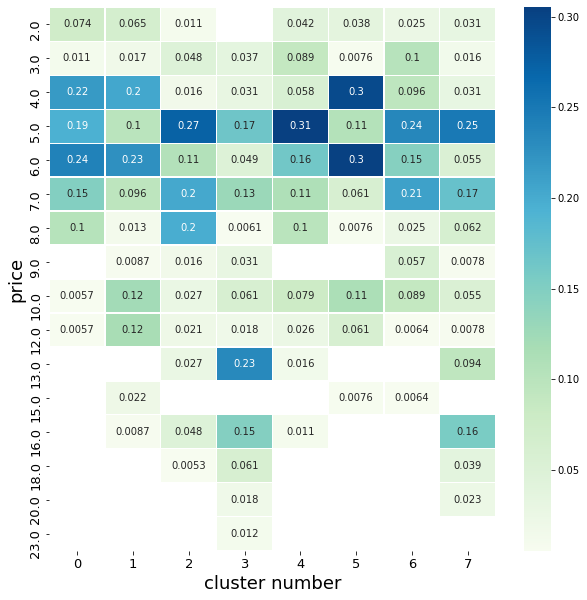

In [179]:
corr_scaled = corr.copy(deep = True)
for i in range(a.shape[1]):
    corr_scaled.iloc[:,i] /= corr_scaled.sum()[i]
plt.figure(figsize=(10,10))
sns.heatmap(corr_scaled,annot=True,cmap='GnBu',linewidths=0.2) 
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('cluster number',fontsize = 18)
plt.ylabel('price',fontsize = 18)
plt.savefig('../../saved_figs/task2/price heat map.pdf', dpi = 1200,bbox_inches = 'tight')
plt.show()

# style shape

tshirt_standard_45-65cm    1260
tshirt_court_(<45cm)         44
body                         43
tshirt_long_(>65cm)          11
dos_nu                        3
tshirt_bandeau                1
Name: style_shape, dtype: int64


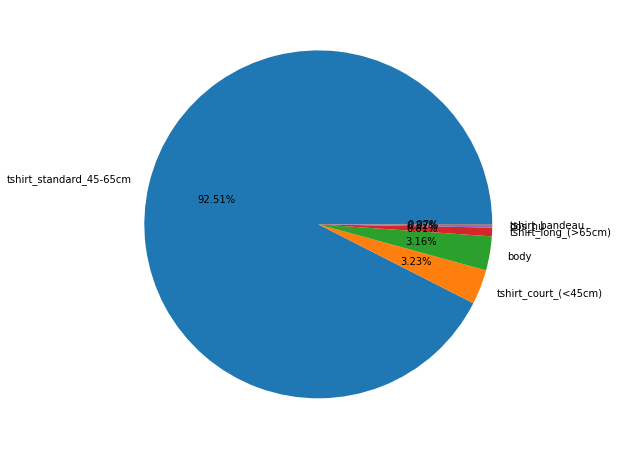

In [44]:
plt.figure(figsize=(8,8))
# plt.title("Distribution of season",fontsize = 11)
sorted_counts = all_raw_features['style_shape'].value_counts()
print(sorted_counts)
plt.pie(x=sorted_counts,labels=sorted_counts.index,autopct="%0.2f%%")
# plt.savefig("../../saved_figs/task_2/Pie chart of season.pdf",dpi=1200)
plt.show()

tshirt_standard_45-65cm    1260
tshirt_court_(<45cm)         44
body                         43
tshirt_long_(>65cm)          11
dos_nu                        3
Name: style_shape, dtype: int64


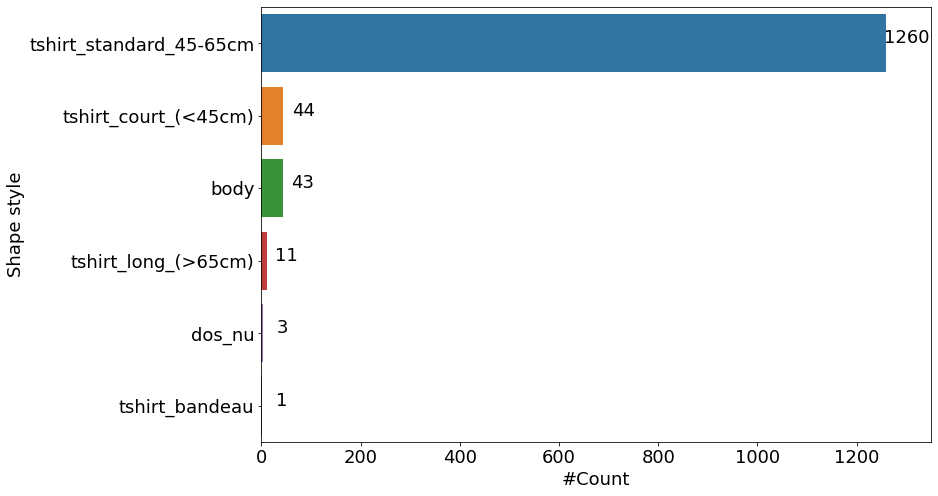

In [199]:
plt.figure(figsize=(12,8))
sorted_counts = all_raw_features['style_shape'].value_counts()
print(sorted_counts.head())
g = sns.barplot(y=sorted_counts.index,x=sorted_counts.values)
g.set_ylabel('Shape style', fontsize=18)
g.set_xlabel('#Count', fontsize=18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlim(0,sorted_counts.values[0]+90)
# rank = sorted(list(sorted_counts.index))
# rank_dict = {}
# for i in range(len(rank)):
#     rank_dict[rank[i]] = i
for i in range(len(sorted_counts)):
    g.text(sorted_counts.values[i]+40,i,sorted_counts.values[i],
           color="black",ha="center",fontsize = 18)
plt.savefig("../../saved_figs/task2/bar chart styleshape.pdf",dpi=1200,bbox_inches = 'tight')
plt.show()

In [50]:
display(all_raw_features.groupby('style_shape')['cluster_num'].value_counts().unstack())

cluster_num,0,1,2,3,4,5,6,7
style_shape,,,,,,,,
body,2.0,7.0,10.0,6.0,3.0,6.0,4.0,5.0
dos_nu,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN
tshirt_bandeau,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
tshirt_court_(<45cm),2.0,15.0,NaN,7.0,10.0,9.0,1.0,NaN
tshirt_long_(>65cm),NaN,6.0,NaN,NaN,NaN,5.0,NaN,NaN
tshirt_standard_45-65cm,171.0,202.0,175.0,149.0,176.0,112.0,152.0,123.0


In [202]:
corr = all_raw_features.groupby('style_shape')['cluster_num'].value_counts().unstack()
display(corr)
corr.to_csv('Task2/shape_corr.csv')

cluster_num,0,1,2,3,4,5,6,7
style_shape,,,,,,,,
body,2.0,7.0,10.0,6.0,3.0,6.0,4.0,5.0
dos_nu,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN
tshirt_bandeau,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
tshirt_court_(<45cm),2.0,15.0,NaN,7.0,10.0,9.0,1.0,NaN
tshirt_long_(>65cm),NaN,6.0,NaN,NaN,NaN,5.0,NaN,NaN
tshirt_standard_45-65cm,171.0,202.0,175.0,149.0,176.0,112.0,152.0,123.0


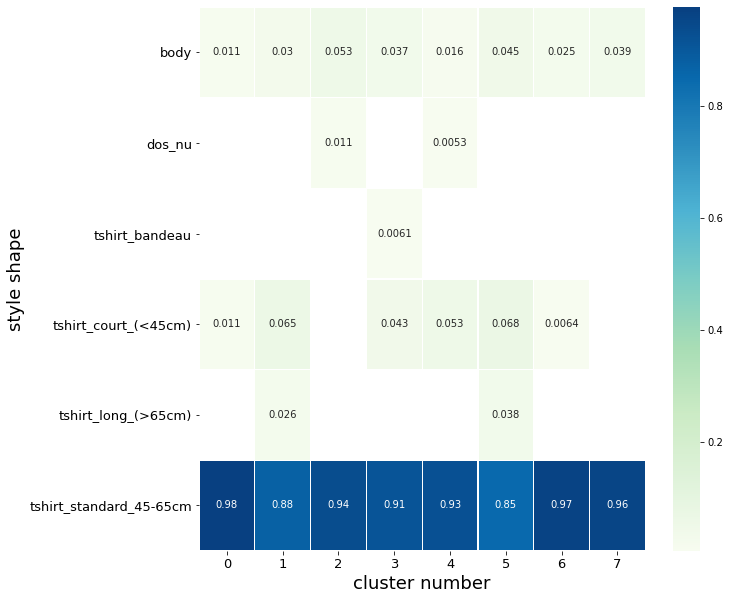

In [205]:
corr_scaled = corr.copy(deep = True)
for i in range(a.shape[1]):
    corr_scaled.iloc[:,i] /= corr_scaled.sum()[i]
plt.figure(figsize=(10,10))
sns.heatmap(corr_scaled,annot=True,cmap='GnBu',linewidths=0.2) 
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel('cluster number',fontsize = 18)
plt.ylabel('style shape',fontsize = 18)
plt.savefig('../../saved_figs/task2/shape heat map.pdf', dpi = 1200,bbox_inches = 'tight')
plt.show()

# style sleeve

manches_courtes    679
manches_longues    273
sans_manches       208
bretelles          155
manches_3/4         39
divers               8
Name: style_sleeve, dtype: int64


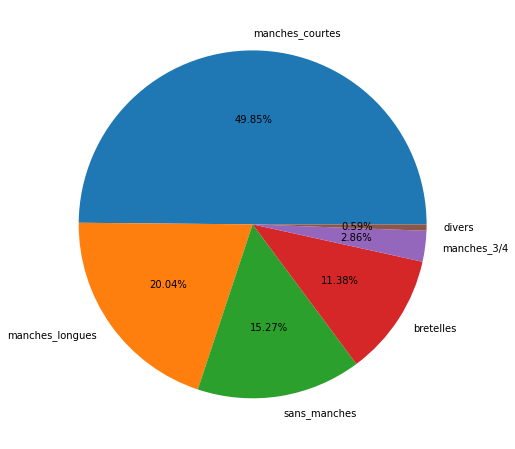

In [206]:
plt.figure(figsize=(8,8))
# plt.title("Distribution of season",fontsize = 11)
sorted_counts = all_raw_features['style_sleeve'].value_counts()
print(sorted_counts)
plt.pie(x=sorted_counts,labels=sorted_counts.index,autopct="%0.2f%%")
plt.savefig("../../saved_figs/task2/Pie chart of sleeve.pdf",dpi=1200,bbox_inches = 'tight')
plt.show()

In [52]:
display(all_raw_features.groupby('style_sleeve')['cluster_num'].value_counts().unstack())

cluster_num,0,1,2,3,4,5,6,7
style_sleeve,,,,,,,,
bretelles,18.0,33.0,7.0,25.0,38.0,11.0,16.0,7.0
divers,NaN,4.0,NaN,1.0,2.0,NaN,1.0,NaN
manches_3/4,10.0,1.0,8.0,NaN,2.0,4.0,14.0,NaN
manches_courtes,78.0,121.0,134.0,67.0,90.0,93.0,55.0,41.0
manches_longues,58.0,1.0,20.0,47.0,13.0,4.0,54.0,76.0
sans_manches,11.0,70.0,18.0,23.0,45.0,20.0,17.0,4.0


In [207]:
corr = all_raw_features.groupby('style_sleeve')['cluster_num'].value_counts().unstack()
display(corr)
corr.to_csv('Task2/sleeve_corr.csv')

cluster_num,0,1,2,3,4,5,6,7
style_sleeve,,,,,,,,
bretelles,18.0,33.0,7.0,25.0,38.0,11.0,16.0,7.0
divers,NaN,4.0,NaN,1.0,2.0,NaN,1.0,NaN
manches_3/4,10.0,1.0,8.0,NaN,2.0,4.0,14.0,NaN
manches_courtes,78.0,121.0,134.0,67.0,90.0,93.0,55.0,41.0
manches_longues,58.0,1.0,20.0,47.0,13.0,4.0,54.0,76.0
sans_manches,11.0,70.0,18.0,23.0,45.0,20.0,17.0,4.0


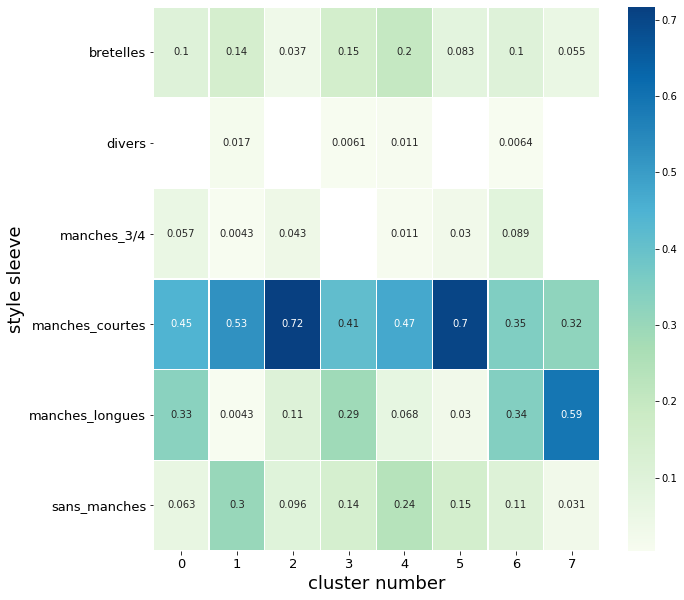

In [209]:
corr_scaled = corr.copy(deep = True)
for i in range(a.shape[1]):
    corr_scaled.iloc[:,i] /= corr_scaled.sum()[i]
plt.figure(figsize=(10,10))
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

sns.heatmap(corr_scaled,annot=True,cmap='GnBu',linewidths=0.2) 
plt.xlabel('cluster number',fontsize = 18)
plt.ylabel('style sleeve',fontsize = 18)

plt.savefig('../../saved_figs/task2/sleeve heat map.pdf', dpi = 1200,bbox_inches = 'tight')
plt.show()

# style collar

col_rond        868
col_v           264
col_monta        76
divers           66
col_carré        34
col_montant      20
col_bateau       11
sans_col          7
col_bénitier      5
col_roulé         5
col_fendu         3
col_bénit         2
col_polo          1
Name: style_collar, dtype: int64


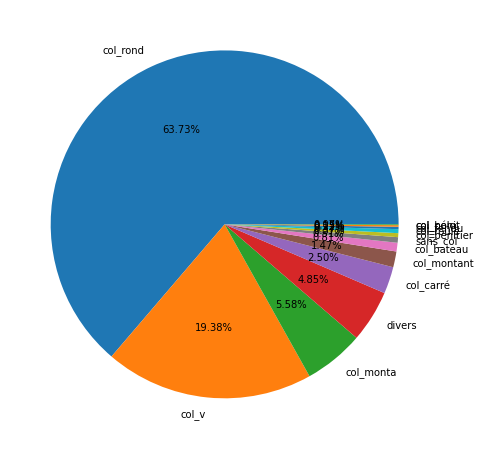

In [54]:
plt.figure(figsize=(8,8))
# plt.title("Distribution of season",fontsize = 11)
sorted_counts = all_raw_features['style_collar'].value_counts()
print(sorted_counts)
plt.pie(x=sorted_counts,labels=sorted_counts.index,autopct="%0.2f%%")
# plt.savefig("../../saved_figs/task_2/Pie chart of season.pdf",dpi=1200)
plt.show()

col_rond     868
col_v        264
col_monta     76
divers        66
col_carré     34
Name: style_collar, dtype: int64


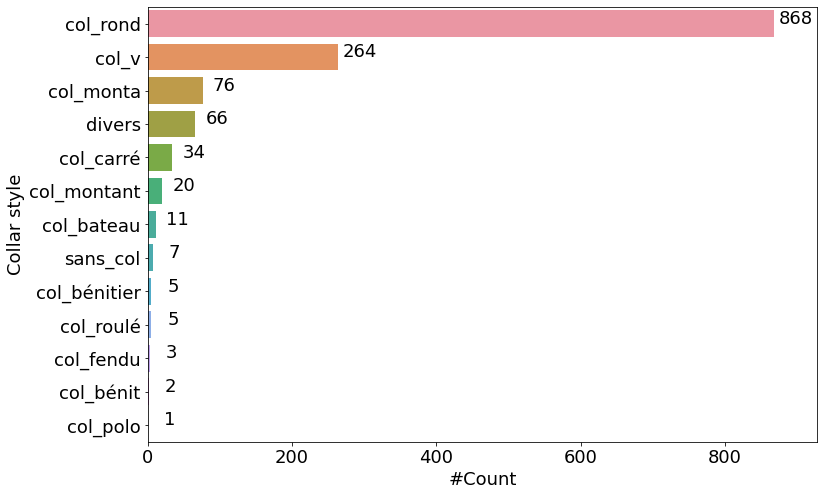

In [216]:
plt.figure(figsize=(12,8))
sorted_counts = all_raw_features['style_collar'].value_counts()
print(sorted_counts.head())
g = sns.barplot(y=sorted_counts.index,x=sorted_counts.values)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
g.set_ylabel('Collar style', fontsize=18)
g.set_xlabel('#Count', fontsize=18)
plt.xlim(0,sorted_counts.values[0]+60)
# rank = sorted(list(sorted_counts.index))
# rank_dict = {}
# for i in range(len(rank)):
#     rank_dict[rank[i]] = i
for i in range(len(sorted_counts)):
    g.text(sorted_counts.values[i]+30,i,sorted_counts.values[i],
           color="black",ha="center",fontsize = 18)
plt.savefig("../../saved_figs/task2/bar chart collar.pdf",dpi=1200,bbox_inches = 'tight')
plt.show()

In [217]:
corr = all_raw_features.groupby('style_collar')['cluster_num'].value_counts().unstack()
display(corr)
corr.to_csv('Task2/collar_corr.csv')

cluster_num,0,1,2,3,4,5,6,7
style_collar,,,,,,,,
col_bateau,3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN
col_bénit,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
col_bénitier,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
col_carré,2.0,17.0,2.0,NaN,6.0,6.0,1.0,NaN
col_fendu,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
col_monta,6.0,NaN,14.0,19.0,NaN,2.0,1.0,34.0
col_montant,2.0,NaN,2.0,11.0,3.0,NaN,2.0,NaN
col_polo,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
col_rond,114.0,150.0,118.0,91.0,120.0,83.0,127.0,65.0


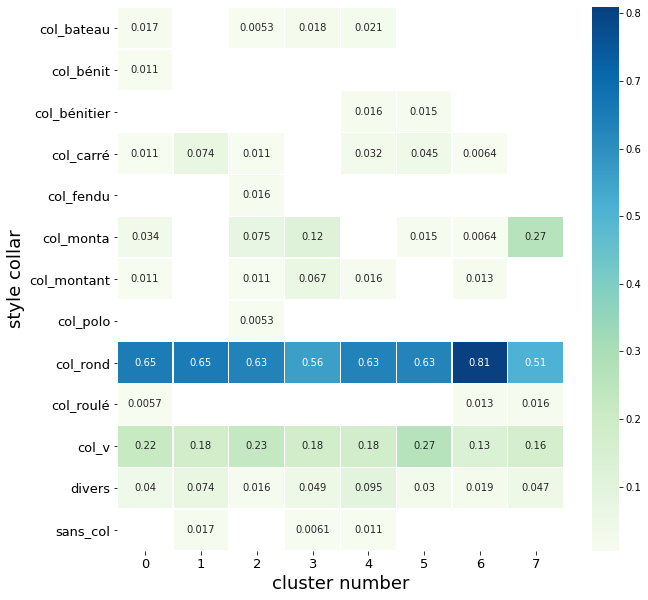

In [219]:
corr_scaled = corr.copy(deep = True)
for i in range(a.shape[1]):
    corr_scaled.iloc[:,i] /= corr_scaled.sum()[i]
plt.figure(figsize=(10,10))
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)


sns.heatmap(corr_scaled,annot=True,cmap='GnBu',linewidths=0.2) 

plt.xlabel('cluster number',fontsize = 18)
plt.ylabel('style collar',fontsize = 18)
plt.savefig('../../saved_figs/task2/collar heat map.pdf', dpi = 1200,bbox_inches = 'tight')
plt.show()

# colour

black     345
white     334
red       117
green     113
blue       88
yellow     85
grey       73
pink       57
brown      50
NaN        44
beige      35
orange     15
purple      6
Name: color, dtype: int64


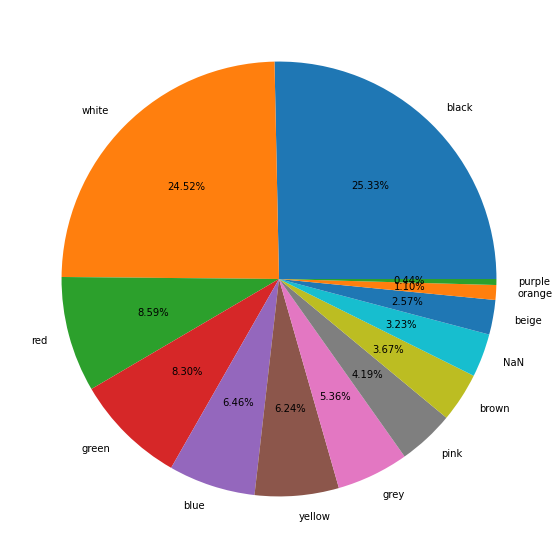

In [220]:
plt.figure(figsize=(10,10))
# plt.title("Distribution of season",fontsize = 11)
sorted_counts = all_raw_features['color'].value_counts()
print(sorted_counts)
plt.pie(x=sorted_counts,labels=sorted_counts.index,autopct="%0.2f%%")
plt.savefig("../../saved_figs/task2/Pie chart of colour.pdf",dpi=1200,bbox_inches = 'tight')
plt.show()

In [221]:
corr = all_raw_features.groupby('color')['cluster_num'].value_counts().unstack()
display(corr)
corr.to_csv('Task2/colour_corr.csv')

cluster_num,0,1,2,3,4,5,6,7
color,,,,,,,,
NaN,8.0,2.0,4.0,14.0,5.0,1.0,6.0,4.0
beige,4.0,2.0,7.0,3.0,4.0,2.0,6.0,7.0
black,54.0,44.0,49.0,56.0,40.0,26.0,44.0,32.0
blue,9.0,20.0,9.0,7.0,12.0,11.0,13.0,7.0
brown,4.0,10.0,6.0,8.0,6.0,3.0,2.0,11.0
green,14.0,23.0,16.0,14.0,14.0,10.0,10.0,12.0
grey,9.0,9.0,7.0,16.0,4.0,2.0,13.0,13.0
orange,2.0,5.0,1.0,NaN,5.0,1.0,1.0,NaN
pink,8.0,13.0,1.0,5.0,8.0,9.0,11.0,2.0


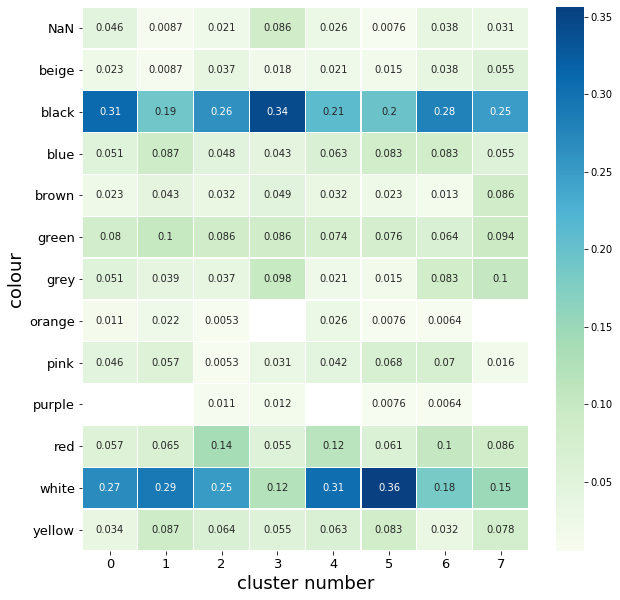

In [222]:
corr_scaled = corr.copy(deep = True)
for i in range(a.shape[1]):
    corr_scaled.iloc[:,i] /= corr_scaled.sum()[i]
plt.figure(figsize=(10,10))
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

sns.heatmap(corr_scaled,annot=True,cmap='GnBu',linewidths=0.2) 
plt.xlabel('cluster number',fontsize = 18)
plt.ylabel('colour',fontsize = 18)
plt.savefig('../../saved_figs/task2/color heat map.pdf', dpi = 1200,bbox_inches = 'tight')
plt.show()

# Name

NaN          828
dentelle     143
imprimé       85
brodé         50
basique       49
maille        40
côtelé        37
débardeur     35
message       33
fines         33
cropped       29
Name: name, dtype: int64


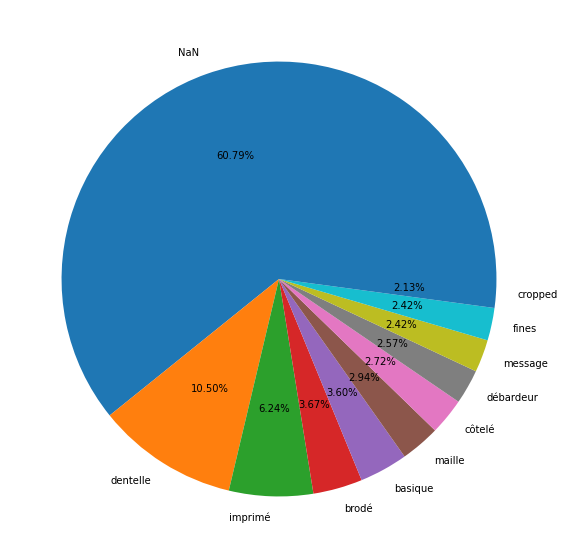

In [223]:
plt.figure(figsize=(10,10))
# plt.title("Distribution of season",fontsize = 11)
sorted_counts = all_raw_features['name'].value_counts()
print(sorted_counts)
plt.pie(x=sorted_counts,labels=sorted_counts.index,autopct="%0.2f%%")
plt.savefig("../../saved_figs/task2/Pie chart of name.pdf",dpi=1200,bbox_inches = 'tight')
plt.show()

In [224]:
corr = all_raw_features.groupby('name')['cluster_num'].value_counts().unstack()
display(corr)
corr.to_csv('Task2/name_corr.csv')

cluster_num,0,1,2,3,4,5,6,7
name,,,,,,,,
NaN,93.0,140.0,116.0,116.0,104.0,73.0,102.0,84.0
basique,4.0,11.0,6.0,NaN,6.0,2.0,19.0,1.0
brodé,9.0,11.0,1.0,NaN,7.0,9.0,9.0,4.0
cropped,2.0,4.0,4.0,7.0,2.0,9.0,1.0,NaN
côtelé,7.0,3.0,3.0,4.0,3.0,3.0,1.0,13.0
dentelle,17.0,22.0,22.0,20.0,16.0,15.0,15.0,16.0
débardeur,2.0,13.0,2.0,2.0,15.0,NaN,NaN,1.0
fines,6.0,6.0,NaN,3.0,12.0,4.0,1.0,1.0
imprimé,18.0,10.0,16.0,3.0,16.0,11.0,5.0,6.0


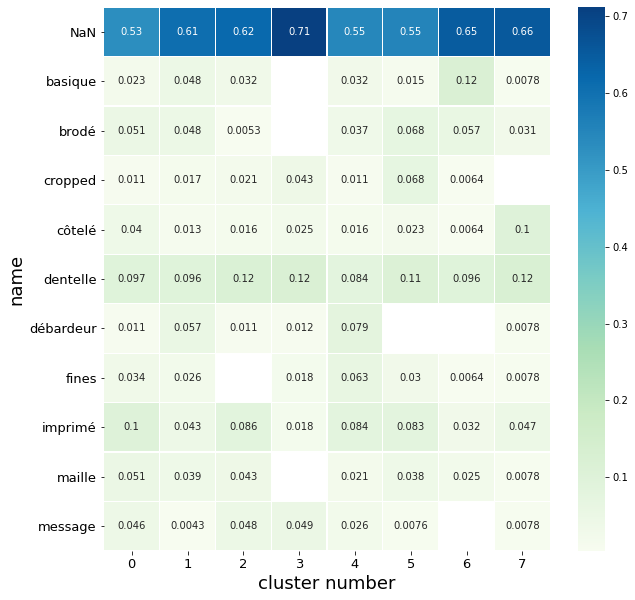

In [226]:
corr_scaled = corr.copy(deep = True)
for i in range(a.shape[1]):
    corr_scaled.iloc[:,i] /= corr_scaled.sum()[i]
plt.figure(figsize=(10,10))
sns.heatmap(corr_scaled,annot=True,cmap='GnBu',linewidths=0.2) 
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.xlabel('cluster number',fontsize = 18)
plt.ylabel('name',fontsize = 18)

plt.savefig('../../saved_figs/task2/name heat map.pdf', dpi = 1200,bbox_inches = 'tight')
plt.show()

# Composition Elasthanne

0    583
5    382
4    109
2     65
6     63
Name: Elasthanne, dtype: int64


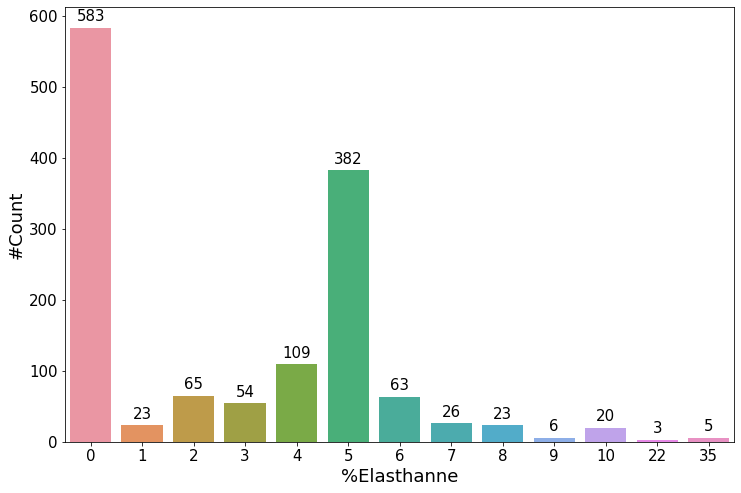

In [229]:
plt.figure(figsize=(12,8))
sorted_counts = EDA_composition['Elasthanne'].value_counts()
print(sorted_counts.head())
g = sns.barplot(x=sorted_counts.index,y=sorted_counts.values)
g.set_xlabel('%Elasthanne', fontsize=18)
g.set_ylabel('#Count', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

rank = sorted(list(sorted_counts.index))
rank_dict = {}
for i in range(len(rank)):
    rank_dict[rank[i]] = i
for i in range(len(sorted_counts)):
    g.text(rank_dict[sorted_counts.index[i]],
           sorted_counts.values[i]+10,sorted_counts.values[i],
           color="black",ha="center", fontsize=15)
plt.savefig("../../saved_figs/task2/bar chart of Elasthanne.pdf",dpi=1200,bbox_inches = 'tight')
plt.show()

In [230]:
corr = EDA_composition.groupby('Elasthanne')['cluster_num'].value_counts().unstack()
display(corr)
corr.to_csv('Task2/Elasthanne_corr.csv')

cluster_num,0,1,2,3,4,5,6,7
Elasthanne,,,,,,,,
0,81.0,119.0,75.0,77.0,79.0,67.0,51.0,34.0
1,NaN,6.0,3.0,NaN,13.0,1.0,NaN,NaN
2,14.0,3.0,4.0,4.0,4.0,10.0,13.0,13.0
3,6.0,14.0,8.0,4.0,7.0,4.0,3.0,8.0
4,10.0,22.0,16.0,13.0,18.0,5.0,7.0,18.0
5,46.0,49.0,57.0,45.0,47.0,36.0,64.0,38.0
6,7.0,12.0,10.0,3.0,10.0,6.0,7.0,8.0
7,6.0,2.0,1.0,3.0,5.0,1.0,8.0,NaN
8,NaN,NaN,6.0,6.0,3.0,NaN,4.0,4.0


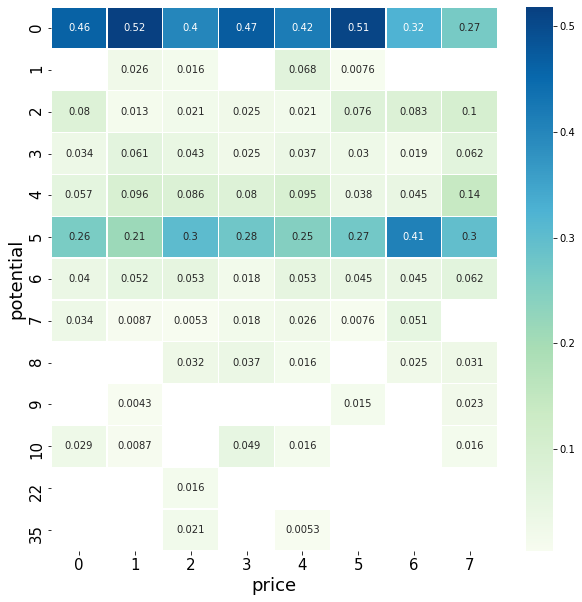

In [231]:
corr_scaled = corr.copy(deep = True)
for i in range(a.shape[1]):
    corr_scaled.iloc[:,i] /= corr_scaled.sum()[i]
plt.figure(figsize=(10,10))
sns.heatmap(corr_scaled,annot=True,cmap='GnBu',linewidths=0.2) 
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.xlabel('price',fontsize = 18)
plt.ylabel('potential',fontsize = 18)
plt.savefig('../../saved_figs/task2/Elasthanne heat map.pdf', dpi = 1200,bbox_inches = 'tight')
plt.show()